# Lesson 6 Assignment - Advertising Sales Regression
Version: Jun-2019
## Author - Lukas FIorio

### Instructions  
Perform four different linear regressions on advertising sales data located in 'Advertising.csv'.  Your dependent feature is 'sales', a measure of sales of a product in a given market in thousands of dollars. 

The independent features for each of the first 3 separate regressions are:

 1. 'TV': advertising dollars spent on TV ads for a single product in a given market
 2. 'radio': advertising dollars spent on radio ads
 3. 'newspaper': advertising dollars spent on newspaper ads

For the first 3 linear regression performed:

- Produce a labeled graph showing the best fit line with the data points.
- Interpret both the slope and y-intercept.
 
The final regression(#4) includes all 3 features: (a) TV, (b) radio, and (c) newspaper. 
- Interpret each partial slope and the intercept parameters.
- Interpret the adjusted R-squared.
- Find and report the mean-squared error.

#### Please prepare this information for a client who may not understand what the parameters mean.


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error

In [2]:
# %matplotlib inline # no longer need plt.show()

In [3]:
# set package options
pd.set_option('display.max_columns', None) # show all columns
plt.rc('patch', force_edgecolor = True) # set bar borders in bar plots
# %matplotlib inline # no longer need plt.show()

In [4]:
# Locate & load dataset
file = 'https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/Advertising.csv'
ads = pd.read_csv(file, index_col=0) # read file into df

### Explore the Data

- preview data
- examine data structure
- describe() data
- view distributions
- compare possible transformations

In [5]:
ads.head() # preview df

,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


In [6]:
ads.info() # examine data structure

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 1 to 200
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   TV         200 non-null    float64
 1   radio      200 non-null    float64
 2   newspaper  200 non-null    float64
 3   sales      200 non-null    float64
dtypes: float64(4)
memory usage: 7.8 KB


In [7]:
ads.describe().apply(lambda s: s.apply(lambda x: format(x, 'g'))) # describe df (rounded)

,TV,radio,newspaper,sales
count,200,200,200,200
mean,147.042,23.264,30.554,14.0225
std,85.8542,14.8468,21.7786,5.21746
min,0.7,0,0.3,1.6
25%,74.375,9.975,12.75,10.375
50%,149.75,22.9,25.75,12.9
75%,218.825,36.525,45.1,17.4
max,296.4,49.6,114,27


#### Examine data distributions

- look relatively normal for the most part, except for newspaper

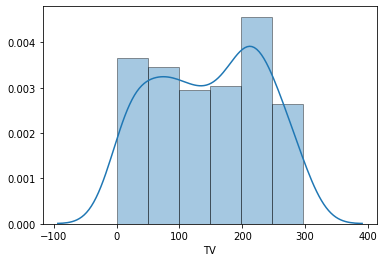

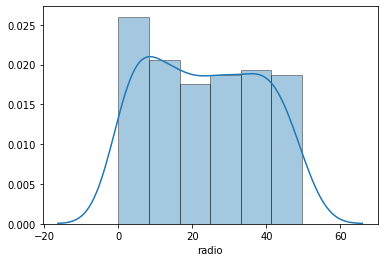

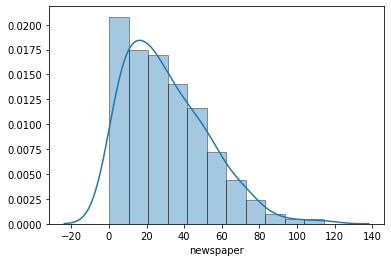

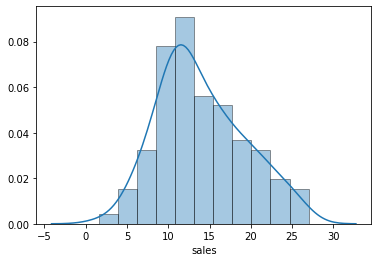

In [8]:
# distribution of data fields
for i, col in enumerate(ads):
    plt.figure(i)
    sns.distplot(ads[col])

#### Compare data transformations for normality

In [9]:
# function to graphically and statistically compare distribution transformations
def compare_transformations(df, col, const=0):
    
    # set plot and axis properties
    fig, axs = plt.subplots(ncols = 3, nrows = 2)
    fig.set_size_inches(12, 8)
    fig.tight_layout(pad=6.0)
    axs[0][0].title.set_text('QQ plot: ' + col)
    axs[0][1].title.set_text('QQ plot: log(' + col + ')')
    axs[0][2].title.set_text('QQ plot: boxcox(' + col + ')')
    axs[1][0].title.set_text('distribution: ' + col)
    axs[1][1].title.set_text('distribution: log(' + col + ')')
    axs[1][2].title.set_text('distribution: boxcox(' + col + ')')

    # store transformations
    log_col = np.log(df[col] + const) # optionally specify a constant to avoid value=0 errors
    # ignore np.NaN warnings specifically for boxcox transformation
    with np.errstate(invalid='ignore'): 
        # optionally specify a constant to avoid value=0 errors
        boxcox_col = pd.Series(ss.boxcox(df[col] + const)[0])
    
    # make QQ plots
    sm.qqplot(df[col], line = 'q', ax = axs[0][0])
    sm.qqplot(log_col, line = 'q', ax = axs[0][1])
    sm.qqplot(boxcox_col, line = 'q', ax = axs[0][2])

    # make distribution plots
    sns.distplot(df[col], kde=False, ax = axs[1][0])
    sns.distplot(log_col, kde=False, ax = axs[1][1])
    sns.distplot(boxcox_col, kde=False, ax = axs[1][2]);
    
    # normalize columns for ks test
    z_col = (df[col] - df[col].mean()) / df[col].std()
    z_col_log = (log_col - log_col.mean()) / log_col.std()
    z_col_boxcox = (boxcox_col - boxcox_col.mean()) / boxcox_col.std()
 
    # print results of ks test
    print(col + ':')
    print(ss.kstest(z_col.dropna(), 'norm'))
    
    print('\nlog(' + col + '):')
    print(ss.kstest(z_col_log.dropna(), 'norm'))
    
    print('\nboxcox(' + col + '):')
    print(ss.kstest(z_col_boxcox.dropna(), 'norm'))

#### TV - untransformed data looks closest to normal (or at least no significant gains offered by transformations)

TV:
KstestResult(statistic=0.08702777360435543, pvalue=0.09105894038816138)

log(TV):
KstestResult(statistic=0.15524745005294116, pvalue=0.00011242355213414466)

boxcox(TV):
KstestResult(statistic=0.10030486896846325, pvalue=0.03327755195384052)


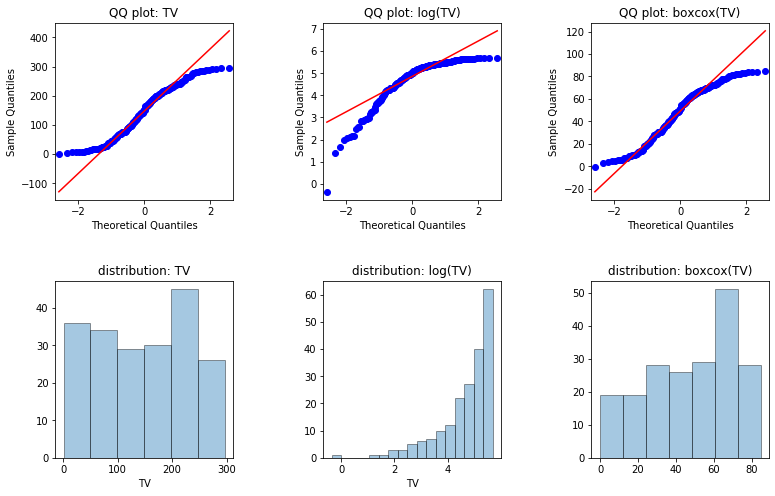

In [10]:
compare_transformations(ads, 'TV')

#### Radio - untransformed data looks closest to normal (or at least no significant gains offered by transformations)

radio:
KstestResult(statistic=0.08395825811656044, pvalue=0.11261277203399504)

log(radio):
KstestResult(statistic=0.13554475616578676, pvalue=0.0011491978755166696)

boxcox(radio):
KstestResult(statistic=0.08552836650090256, pvalue=0.10111256339612472)


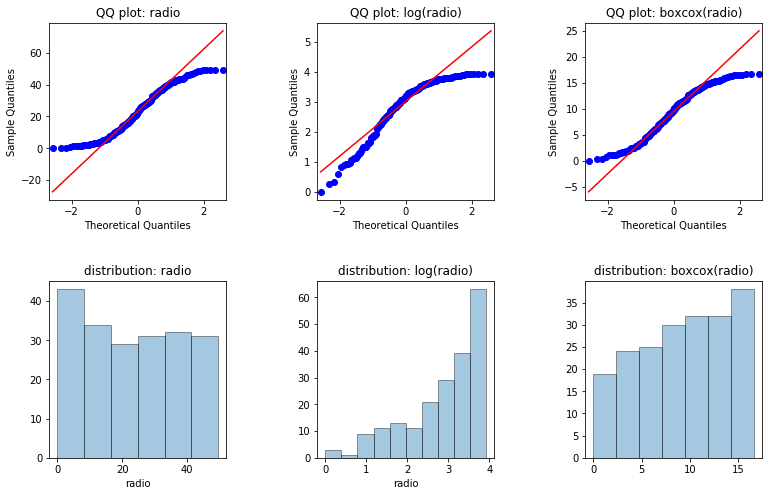

In [11]:
compare_transformations(ads, 'radio', const=1)

#### newspaper - boxcox transformed data looks <ins>much</ins> closer to normal

newspaper:
KstestResult(statistic=0.09850995031682896, pvalue=0.03844791153432069)

log(newspaper):
KstestResult(statistic=0.10383737246665337, pvalue=0.024854275546150318)

boxcox(newspaper):
KstestResult(statistic=0.05155430780453693, pvalue=0.6677680726780165)


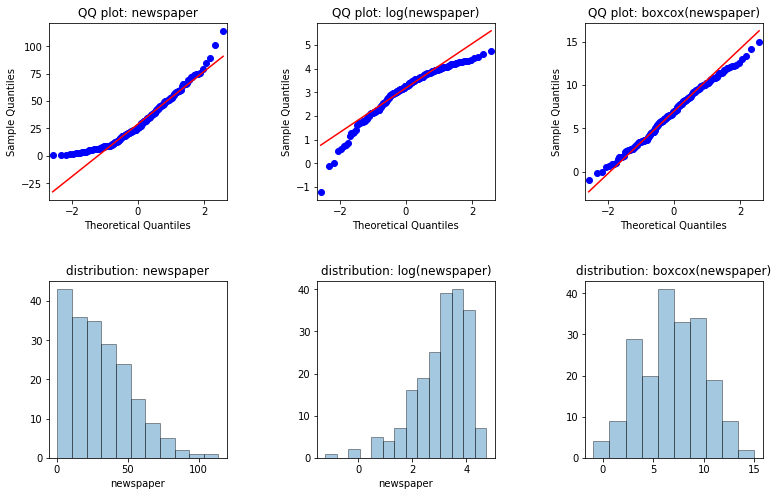

In [12]:
compare_transformations(ads, 'newspaper')

#### sales - untransformed data looks closest to normal (or at least no significant gains offered by transformations)

sales:
KstestResult(statistic=0.09517214063446572, pvalue=0.04994556266196435)

log(sales):
KstestResult(statistic=0.05522287463408185, pvalue=0.5695108101516275)

boxcox(sales):
KstestResult(statistic=0.06408896551327936, pvalue=0.3707454286483024)


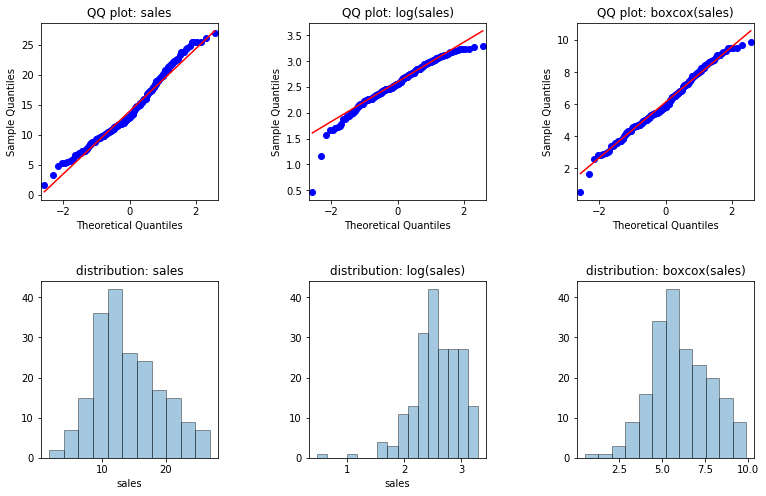

In [13]:
compare_transformations(ads, 'sales')

####  Based on above add a box clox transformation on `newspaper` column

- we lose interpretability, but will see how well it predicts compared to untransformed newspaper (just for fun)

In [14]:
ads['box_newspaper'] = list(ss.boxcox(ads['newspaper'] + 1)[0])

## Fit linear models for each type of ad spend

- TV
- radio
- newspaper

### `TV` model:

RMSE of 3.242 (MSE = 10.513)
- The standard deviation of our prediction errors is 3.242.
- Interpretation: A typical prediction (based on TV ad spend) is off by about \\$3242 in product sales.

Adjusted R$^2$ of .610.
- Interpretation: 61\% of variance in product sales is explained by TV ad spend.

Intercept of 7.032.
- Interpretation: We would expect - on average - \\$7032 in product sales when spending \\$0 on TV ads.

Slope of 0.0475
- Interpretation: For every \\$1 spent on TV ads we would - on average - expect \\$47.50 in additional sales ($1000 * .0475)

In [15]:
# initialize & fit model
ols_model_tv = smf.ols(formula = 'sales ~ TV', data = ads)
ols_model_tv = ols_model_tv.fit()

# make predictions
sales_pred_tv = ols_model_tv.predict(ads['TV'])

# calculate MSE (and RMSE)
mse_tv = mean_squared_error(ads['sales'], sales_pred_tv, squared = True) # obtain MSE
rmse_tv = np.sqrt(mse_tv)

In [16]:
print('MSE: ', round(mse_tv, 3))
print('RMSE: ', round(rmse_tv, 3))

MSE:  10.513
RMSE:  3.242


In [17]:
# show model summary
print(ols_model_tv.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     312.1
Date:                Sun, 09 Aug 2020   Prob (F-statistic):           1.47e-42
Time:                        00:20:51   Log-Likelihood:                -519.05
No. Observations:                 200   AIC:                             1042.
Df Residuals:                     198   BIC:                             1049.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0326      0.458     15.360      0.0

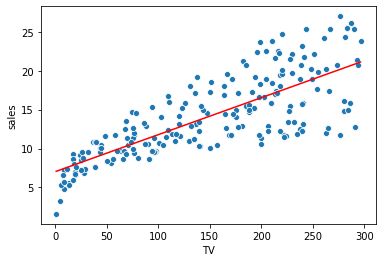

In [18]:
# plot sales vs TV ad spend
sns.scatterplot(ads['TV'], ads['sales'])
sns.lineplot(ads['TV'], sales_pred_tv, color = 'red') # display predictions

### `radio` model:

RMSE of 4.254 (MSE = 18.092)
- The standard deviation of our prediction errors is 4.254.
- Interpretation: A typical prediction (based on radio ad spend) is off by about \\$4254 in product sales.

Adjusted R$^2$ of .329.
- Interpretation: 33\% of variance in product sales is explained by radio ad spend.

Intercept of 9.311.
- Interpretation: We would expect - on average - \\$9311 in product sales when spending \\$0 on radio ads.

Slope of 0.2025
- Interpretation: For every \\$1 spent on radio ads we would - on average - expect \\$202.50 in additional sales ($1000 * .2025)

In [19]:
# initialize & fit model
ols_model_radio = smf.ols(formula = 'sales ~ radio', data = ads)
ols_model_radio = ols_model_radio.fit()

# make predictions
sales_pred_radio = ols_model_radio.predict(ads['radio'])

# calculate MSE (and RMSE)
mse_radio = mean_squared_error(ads['sales'], sales_pred_radio, squared = True) # obtain MSE
rmse_radio = np.sqrt(mse_radio)

In [20]:
print('MSE: ', round(mse_radio, 3))
print('RMSE: ', round(rmse_radio, 3))

MSE:  18.092
RMSE:  4.254


In [21]:
# show model summary
print(ols_model_radio.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.332
Model:                            OLS   Adj. R-squared:                  0.329
Method:                 Least Squares   F-statistic:                     98.42
Date:                Sun, 09 Aug 2020   Prob (F-statistic):           4.35e-19
Time:                        00:20:51   Log-Likelihood:                -573.34
No. Observations:                 200   AIC:                             1151.
Df Residuals:                     198   BIC:                             1157.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.3116      0.563     16.542      0.0

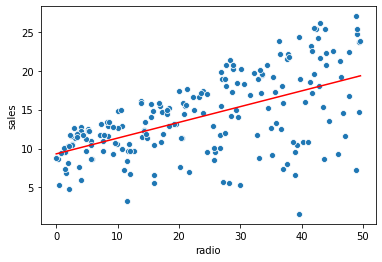

In [22]:
# plot sales vs radio ad spend
sns.scatterplot(ads['radio'], ads['sales'])
sns.lineplot(ads['radio'], sales_pred_radio, color = 'red') # display predictions

### `newspaper` model:

RMSE of 5.067 (MSE = 25.674)
- The standard deviation of our prediction errors is 5.067.
- Interpretation: A typical prediction (based on newspaper ad spend) is off by about \\$5067 in product sales.

Adjusted R$^2$ of .047.
- Interpretation: 5\% of variance in product sales is explained by newspaper ad spend.

Intercept of 12.351.
- Interpretation: We would expect - on average - \\$12351 in product sales when spending \\$0 on newspaper ads.

Slope of 0.0547
- Interpretation: For every \\$1 spent on newspaper ads we would - on average - expect \\$54.70 in additional sales ($1000 * .0547)

In [23]:
# initialize & fit model
ols_model_news = smf.ols(formula = 'sales ~ newspaper', data = ads)
ols_model_news = ols_model_news.fit()

# make predictions
sales_pred_news = ols_model_news.predict(ads['newspaper'])

# calculate MSE (and RMSE)
mse_news = mean_squared_error(ads['sales'], sales_pred_news, squared = True) # obtain MSE
rmse_news = np.sqrt(mse_news)

In [24]:
print('MSE: ', round(mse_news, 3))
print('RMSE: ', round(rmse_news, 3))

MSE:  25.674
RMSE:  5.067


In [25]:
# show model summary
print(ols_model_news.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     10.89
Date:                Sun, 09 Aug 2020   Prob (F-statistic):            0.00115
Time:                        00:20:52   Log-Likelihood:                -608.34
No. Observations:                 200   AIC:                             1221.
Df Residuals:                     198   BIC:                             1227.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.3514      0.621     19.876      0.0

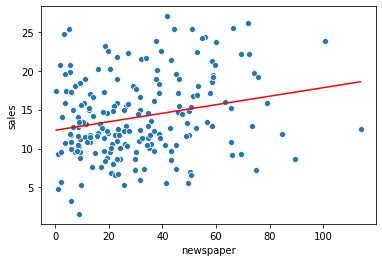

In [26]:
# plot sales vs newspaper ad spend
sns.scatterplot(ads['newspaper'], ads['sales'])
sns.lineplot(ads['newspaper'], sales_pred_news, color = 'red') # display predictions

### `boxcox(newspaper)` model (for fun):

Even  worse than the untransformed `newspaper` model unfortunately :(

RMSE of 5.1 (MSE = 26.013)
- The standard deviation of our prediction errors is 5.1.
- Interpretation: A typical prediction (based on newspaper ad spend) is off by about \\$5100 in product sales.

Adjusted R$^2$ of .035.
- Interpretation: 3.5\% of variance in product sales is explained by newspaper ad spend.

Intercept of 11.509.
- Interpretation: Lost with boxcox transformation.

Slope of 0.3847
- Interpretation: Lost with boxcox transformation

In [27]:
# initialize & fit model
ols_model_bc_news = smf.ols(formula = 'sales ~ box_newspaper', data = ads)
ols_model_bc_news = ols_model_bc_news.fit()

# make predictions
sales_pred_bc_news = ols_model_bc_news.predict(ads['box_newspaper'])

# calculate MSE (and RMSE)
mse_bc_news = mean_squared_error(ads['sales'], sales_pred_bc_news, squared = True) # obtain MSE
rmse_bc_news = np.sqrt(mse_bc_news)

In [28]:
print('MSE: ', round(mse_bc_news, 3))
print('RMSE: ', round(rmse_bc_news, 3))

MSE:  26.013
RMSE:  5.1


In [29]:
# show model summary
print(ols_model_bc_news.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     8.162
Date:                Sun, 09 Aug 2020   Prob (F-statistic):            0.00473
Time:                        00:20:53   Log-Likelihood:                -609.65
No. Observations:                 200   AIC:                             1223.
Df Residuals:                     198   BIC:                             1230.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        11.5090      0.952     12.095

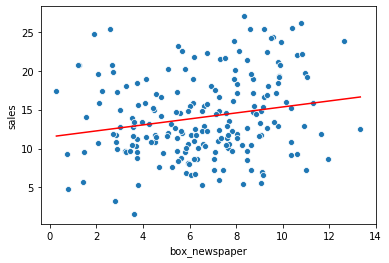

In [30]:
# plot sales vs boxcox(newspaper) ad spend
sns.scatterplot(ads['box_newspaper'], ads['sales'])
sns.lineplot(ads['box_newspaper'], sales_pred_bc_news, color = 'red') # display predictions

## Now Use all 3 independent variables to predict product sales

### `TV` + `radio` + `newspaper` model:

RMSE of 1.669 (MSE = 2.784)
- The standard deviation of our prediction errors is 1.669.
- Interpretation: A typical prediction (based on all types of ad spend) is off by about \\$1669 in product sales.

Adjusted R$^2$ of .897.
- Interpretation: 90\% of variance in product sales is explained by ad spend.

Intercept of 2.939.
- Interpretation: We would expect - on average - \\$2939 in product sales when spending \\$0 on ads.

Slopes:
- `TV` : .0458
- `radio` : .1885
- `newspaper`: -.0010
- Interpretations: For every \\$1 spent on...
  - **TV ads**: we expect a return of \\$45.80 in product sales (on average; controlling for radio, newspaper)
  - **radio ads**: we expect a return of \\$188.50 in product sales (on average; controlling for TV, newspaper)
  - **newspaper ads**: we expect a return of -\\$10 in product sales (on average; controlling for TV, radio)

In [31]:
# initialize & fit model
ols_model_all = smf.ols(formula = 'sales ~ TV + radio + newspaper', data = ads)
ols_model_all = ols_model_all.fit()

# make predictions
sales_pred_all = ols_model_all.predict(ads[['TV', 'radio', 'newspaper']])

# calculate MSE (and RMSE)
mse_all = mean_squared_error(ads['sales'], sales_pred_all, squared = True) # obtain MSE
rmse_all = np.sqrt(mse_all)

In [32]:
print('MSE: ', round(mse_all, 3))
print('RMSE: ', round(rmse_all, 3))

MSE:  2.784
RMSE:  1.669


In [33]:
# show model summary
print(ols_model_all.summary())

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Sun, 09 Aug 2020   Prob (F-statistic):           1.58e-96
Time:                        00:20:54   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9389      0.312      9.422      0.0

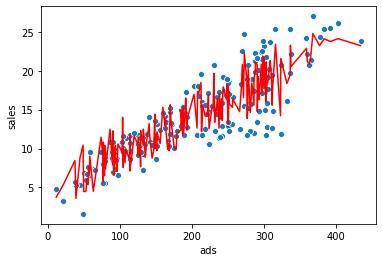

In [34]:
# combine ad spend types into a total column
ads['ads']= ads.iloc[:, 0:3].sum(axis=1)

# plot sales vs total ad spend
sns.scatterplot(ads['ads'], ads['sales'])
sns.lineplot(ads['ads'], sales_pred_all, color = 'red') # display predictions

## Conclusion

- The best model used all 3 independent variables, outperforming each of the individual models
- Noted that newspaper ad spend appears to have very little affect (cannot reject H$_0$ of slope $\neq$ 0)
- Recommend client to stop spending on newspaper ads...
- Note that final plot is linear combinations of independent variables, but not actually a single straight line
- Lastly we were sadly disappointed that our boxcox transformation on newspaper spend had no improvement on predictions :(  Although it did make the distribution much closer to normal, so we were happy about that :)